In [ ]:
!pip install -Uq langchain langchain-openai langgraph

In [1]:
!pip install -Uq langchain langchain-openai langgraph

In [ ]:
import os
from langchain_openai import AzureChatOpenAI
os.environ["OPENAI_API_VERSION"] = "2024-12-01-preview"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://ai-agents-sept-cohort-resource.cognitiveservices.azure.com/"
os.environ["AZURE_OPENAI_API_KEY"] = ""

os.environ['LANGSMITH_TRACING'] ='true'
os.environ['LANGSMITH_ENDPOINT']='https://api.smith.langchain.com'
os.environ['LANGSMITH_API_KEY']=''
os.environ['LANGSMITH_PROJECT']='cohort-3-langgraph'

os.environ["PINECONE_API_KEY"]=''

In [3]:
llm = AzureChatOpenAI(
  deployment_name = "gpt-4.1",
  temperature=1,
  top_p=0.8
)

llm.invoke('hello')

AIMessage(content='Hello! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_f99638a8d7', 'id': 'chatcmpl-D1P0Tq67taQfBakImaiavECK4CTdg', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'

In [5]:
from langchain.agents import create_agent

def get_bank_balance():
  """Tool providing bank balance of user"""
  return "Bank balance is 5000"

def withdraw_amount(amount: int):
  """Tool to withdraw given amount"""
  return "Amount withdrawn succesfully"

banking_agent = create_agent(llm, tools=[get_bank_balance, withdraw_amount])

banking_agent.invoke({
  'messages': 'i would like to withdraw 6000'
})

{'messages': [HumanMessage(content='i would like to withdraw 6000', additional_kwargs={}, response_metadata={}, id='dabccdec-0147-4a7e-a1b0-9ae9cdfdc3b5'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 67, 'total_tokens': 79, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_b9041e10b4', 'id': 'chatcmpl-D1P5L4gQDhYyXveFv3svutsFEAlE9', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': '

In [11]:
from typing import Annotated, Literal, Sequence, TypedDict, Any
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    agent_trace: Sequence[BaseMessage]

def input_check_node(state: AgentState):
  print('input_check_node called')
  return state

def get_banking_agents_response(state: AgentState):
  print('get_banking_agents_response called')
  query = state['messages'][-1]
  response = banking_agent.invoke({
    'messages': 'i would like to withdraw 6000'
  })
  return {'messages': [response['messages'][-1]], 'agent_trace': response}
  
def output_sanitize_node(state: AgentState):
  print('output_sanitize_node called')
  return state

In [12]:
graph_builder = StateGraph(AgentState)
graph_builder.add_node('input_check_node', input_check_node)
graph_builder.add_node('get_banking_agents_response', get_banking_agents_response)
graph_builder.add_node('output_sanitize_node', output_sanitize_node)

graph_builder.add_edge(START, 'input_check_node')
graph_builder.add_edge('input_check_node', 'get_banking_agents_response')
graph_builder.add_edge('get_banking_agents_response', 'output_sanitize_node')

graph = graph_builder.compile()

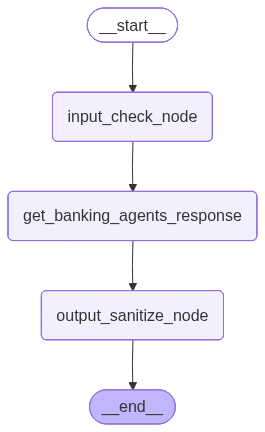

In [10]:
# 6. Visualize Graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
response = graph.invoke({
  'messages': 'what is my bank balance'
})
response

input_check_node called get_banking_agents_response called 
 output_sanitize_node called {'messages': [HumanMessage(content='what is my bank balance', additional_kwargs={}, response_metadata={}, id='173b9956-12d1-42ea-8a44-fd7b8f07059d'),
 AIMessage(content="You currently have a bank balance of 5,000, which is less than the 6,000 you want to withdraw. You won't be able to withdraw the full amount.\n\nWould you like to withdraw the available 5,000 instead, or do you have another amount in mind?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 93, 'total_tokens': 153, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_b9041e10b4', 'id': 'chatcmpl-D1PEWKU74TDRuWzAjULe6rBaWWbD1', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'detected': False, 'filtered': False}, 'protected_material_text': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}, id='lc_run--019bee30-395d-7e81-b186-a9047c018781-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 93, 'output_tokens': 60, 'total_tokens': 153, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})],
 'agent_trace': {'messages': [HumanMessage(content='i would like to withdraw 6000', additional_kwargs={}, response_metadata={}, id='3e51ae23-ff31-43ed-b384-ad69c26f4d78'),
 AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 67, 'total_tokens': 79, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_b9041e10b4', 'id': 'chatcmpl-D1PEVdrjmqrDT3NNONtlTCQylAfT2', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='lc_run--019bee30-321f-7b23-ad75-e2f103a09450-0', tool_calls=[{'name': 'get_bank_balance', 'args': {}, 'id': 'call_gNsYdutDW1zEOKyZ2c3AsaMi', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 67, 'output_tokens': 12, 'total_tokens': 79, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 ToolMessage(content='Bank balance is 5000', name='get_bank_balance', id='de9df784-35aa-4ad6-aac2-7a306d201f01', tool_call_id='call_gNsYdutDW1zEOKyZ2c3AsaMi'),
 AIMessage(content="You currently have a bank balance of 5,000, which is less than the 6,000 you want to withdraw. You won't be able to withdraw the full amount.\n\nWould you like to withdraw the available 5,000 instead, or do you have another amount in mind?", additional_kwargs={'refusal': None}, response_metadata={'token_usage

In [ ]:
# HITL
# Short Term
# Long Term

In [15]:
! pip install -q langgraph-checkpoint-sqlite

In [18]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

conn = sqlite3.connect("checkpoints_langgraph.sqlite", check_same_thread=False)

sqlite_checkpointer = SqliteSaver(conn)

In [20]:
# Compile Graph with SQLite Memory
graph = graph_builder.compile(checkpointer=sqlite_checkpointer)

In [22]:
config = {"configurable": {"thread_id": "1"}}

graph.invoke({
  'messages': 'i would like to withdraw 100 rs'
}, config)

input_check_node called get_banking_agents_response called 
 output_sanitize_node called {'messages': [HumanMessage(content='i would like to withdraw 100 rs', additional_kwargs={}, response_metadata={}, id='02edbe93-e1ae-4a3b-ae8f-7dd227f3d9d8'),
 AIMessage(content='Your current bank balance is 5,000, which is less than the 6,000 you want to withdraw. You cannot withdraw more than your available balance.\n\nWould you like to withdraw a different amount or need help with something else?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 93, 'total_tokens': 143, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_b9041e10b4', 'id': 'chatcmpl-D1PRBKerRotAAqo8RjTXCJ8dIS0YL', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'detected': False, 'filtered': False}, 'protected_material_text': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}, id='lc_run--019bee3c-33ff-77a2-9f40-b2072e50aa0e-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 93, 'output_tokens': 50, 'total_tokens': 143, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})],
 'agent_trace': {'messages': [HumanMessage(content='i would like to withdraw 6000', additional_kwargs={}, response_metadata={}, id='04a4f7ec-94c9-4360-b9bb-6d3e9e344835'),
 AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 67, 'total_tokens': 79, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_b9041e10b4', 'id': 'chatcmpl-D1PRAXkXDTAlg9s5ztvBNxk5QWr7X', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='lc_run--019bee3c-2cb6-76b0-8502-91a378703e6c-0', tool_calls=[{'name': 'get_bank_balance', 'args': {}, 'id': 'call_MDku9hn9aI9tlLscaRsZDbhy', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 67, 'output_tokens': 12, 'total_tokens': 79, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 ToolMessage(content='Bank balance is 5000', name='get_bank_balance', id='e3bf3ff8-ff80-4122-8dd1-4f3f44479334', tool_call_id='call_MDku9hn9aI9tlLscaRsZDbhy'),
 AIMessage(content='Your current bank balance is 5,000, which is less than the 6,000 you want to withdraw. You cannot withdraw more than your available balance.\n\nWould you like to withdraw a different amount or need help with something else?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens':

In [28]:
## Human In The Loop
from langgraph.types import interrupt, Command

def withdraw_amount(amount: int):
  """Tool to withdraw given amount"""
  print('Withdraw tool being called')
  feedback = interrupt({
    'message': "User has requested for a withdrawal",
    'amount': amount
  })
  
  if feedback == 'yes':
    return 'Withdrawal successful, your remaining balance is 1000'
  else:
    return 'Withdrawal request rejected by the bank'

banking_agent = create_agent(llm, tools=[get_bank_balance, withdraw_amount])

In [34]:
def get_banking_agents_response(state: AgentState):
  print('get_banking_agents_response called')
  query = state['messages'][-1]
  response = banking_agent.invoke({
    'messages': query
  })
  return {'messages': [response['messages'][-1]], 'agent_trace': response}

graph_builder = StateGraph(AgentState)
graph_builder.add_node('input_check_node', input_check_node)
graph_builder.add_node('get_banking_agents_response', get_banking_agents_response)
graph_builder.add_node('output_sanitize_node', output_sanitize_node)

graph_builder.add_edge(START, 'input_check_node')
graph_builder.add_edge('input_check_node', 'get_banking_agents_response')
graph_builder.add_edge('get_banking_agents_response', 'output_sanitize_node')

graph = graph_builder.compile(checkpointer=sqlite_checkpointer)

In [35]:
config = {"configurable": {"thread_id": "3"}}

response = graph.invoke({
  'messages': ['I would like to withdraw 1000 rs']
}, config)

input_check_node called get_banking_agents_response called 
 Withdraw tool being called

In [36]:
response

{'messages': [HumanMessage(content='I would like to withdraw 1000 rs', additional_kwargs={}, response_metadata={}, id='031aa00d-fd84-4372-95ec-3028fba86bb4')],
 '__interrupt__': [Interrupt(value={'message': 'User has requested for a withdrawal', 'amount': 1000}, id='b8185271549e7d234f9d3e8c984b4c08')]}

In [ ]:
user -> frontend -> call the backend graph api
        frontend <- interrupt
        frontend -> human agents UI (interrupt message)
        frontend <- human agents response to the query
        frontend -> call the backend graph api with human feedback
        frontend <- final response from the graph api
user <- frontend


In [37]:
graph.invoke(Command(resume="no"), config)

get_banking_agents_response called Withdraw tool being called 
 output_sanitize_node called {'messages': [HumanMessage(content='I would like to withdraw 1000 rs', additional_kwargs={}, response_metadata={}, id='031aa00d-fd84-4372-95ec-3028fba86bb4'),
 AIMessage(content="Your withdrawal request for 1000 rs was rejected by the bank. If you'd like, I can help you check possible reasons (like daily withdrawal limits or account restrictions), or assist with a different amount. Let me know how you'd like to proceed!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 123, 'total_tokens': 175, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_b9041e10b4', 'id': 'chatcmpl-D1Pdf2BIm0prEwXyWkAaaU2LtOENC', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'detected': False, 'filtered': False}, 'protected_material_text': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}, id='lc_run--019bee47-fed5-7e50-997a-b4cbf77c02fa-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 123, 'output_tokens': 52, 'total_tokens': 175, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})],
 'agent_trace': {'messages': [HumanMessage(content='I would like to withdraw 1000 rs', additional_kwargs={}, response_metadata={}, id='031aa00d-fd84-4372-95ec-3028fba86bb4'),
 AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 68, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_b9041e10b4', 'id': 'chatcmpl-D1PZ6Osgu7LahaWSEiPEBGxpMCwpb', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='lc_run--019bee43-ad90-7ae1-91db-1b1606809c80-0', tool_calls=[{'name': 'get_bank_balance', 'args': {}, 'id': 'call_C0xHIrsgjasi316Sle3x4JcP', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 68, 'output_tokens': 12, 'total_tokens': 80, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 ToolMessage(content='Bank balance is 5000', name='get_bank_balance', id='f5058b81-e1eb-4af6-af2e-9742d0096229', tool_call_id='call_C0xHIrsgjasi316Sle3x4JcP'),
 AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 94, 'total_tokens': 110, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt

In [42]:
config = {"configurable": {"thread_id": "4"}}

response = graph.invoke({
  'messages': ['I would like to withdraw 1000 rs']
}, config)

start
input_check_node called -> state is stored
get_banking_agents_response called -> state is stored
output_sanitize_node called -> state is stored
end

input_check_node called get_banking_agents_response called 
 Withdraw tool being called

In [39]:
response

{'messages': [HumanMessage(content='I would like to withdraw 1000 rs', additional_kwargs={}, response_metadata={}, id='cdd448a9-5476-43cb-b107-2961926304bf')],
 '__interrupt__': [Interrupt(value={'message': 'User has requested for a withdrawal', 'amount': 1000}, id='a26f0faff7c71cc557c40811e68f274c')]}

In [43]:
graph.invoke(Command(resume="no"), config)

get_banking_agents_response called Withdraw tool being called 
 output_sanitize_node called {'messages': [HumanMessage(content='I would like to withdraw 1000 rs', additional_kwargs={}, response_metadata={}, id='cdd448a9-5476-43cb-b107-2961926304bf'),
 AIMessage(content='Your withdrawal of 1000 rupees was successful. Your remaining bank balance is 1000 rupees. \n\nIf you need further assistance or want to make another transaction, please let me know!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 127, 'total_tokens': 169, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_b9041e10b4', 'id': 'chatcmpl-D1PqZeGHsJV31JVyiHU6Jt9ssy6Pq', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'detected': False, 'filtered': False}, 'protected_material_text': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}, id='lc_run--019bee54-342a-7fd0-8abf-57810fb0775a-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 127, 'output_tokens': 42, 'total_tokens': 169, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 HumanMessage(content='I would like to withdraw 1000 rs', additional_kwargs={}, response_metadata={}, id='4e042e1d-0547-43c6-ae02-07341196441a'),
 AIMessage(content='Your withdrawal request for 1000 Rs was rejected by the bank. \n\nWould you like to try a different amount or need assistance with something else?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 123, 'total_tokens': 155, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_b9041e10b4', 'id': 'chatcmpl-D1Pr7arZscOFvwOgBl1QRqzXw0Uxj', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'detected': False, 'filtered': False}, 'protected_material_text': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}, id='lc_run--019bee54-baf8-7bd3-8137-719c4a6f26fd-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 123, 'output_tokens': 32, 'total_tokens': 155, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})],
 'agent_trace': {'messages': [HumanMessage(content='I would like to withdraw 1000 rs', additional_kwargs={}, response_metadata={}, id='4e042e1d-0547-43c6-ae02-07341196441a'),
 

In [44]:
! ls

0132667023-HDFC-Life-Group-Unit-Linked-Future-Secure-Plan.pdf checkpoints_langgraph.sqlite checkpoints_langgraph.sqlite-shm checkpoints_langgraph.sqlite-wal checkpoints.sqlite HDFC-GROUP-GRATUITY-BROCHURE.pdf HDFC-Life-Group-Term-Insurance-Plan.pdf HDFC-LIFE-Group-Variable-Employee-Benefit-Plan.pdf lost+found sales_data.db

In [47]:
# The states are returned in reverse chronological order.
states = list(graph.get_state_history(config))

for state in states:
    print(state.next)
    for message in state.values['messages']:
      print(message)
    
    print('*'* 100)

() content='I would like to withdraw 1000 rs' additional_kwargs={} response_metadata={} id='cdd448a9-5476-43cb-b107-2961926304bf' content='Your withdrawal of 1000 rupees was successful. Your remaining bank balance is 1000 rupees. \n\nIf you need further assistance or want to make another transaction, please let me know!' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 127, 'total_tokens': 169, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_b9041e10b4', 'id': 'chatcmpl-D1PqZeGHsJV31JVyiHU6Jt9ssy6Pq', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'detected': False, 'filtered': False}, 'protected_material_text': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}} id='lc_run--019bee54-342a-7fd0-8abf-57810fb0775a-0' tool_calls=[] invalid_tool_calls=[] usage_metadata={'input_tokens': 127, 'output_tokens': 42, 'total_tokens': 169, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}} content='I would like to withdraw 1000 rs' additional_kwargs={} response_metadata={} id='4e042e1d-0547-43c6-ae02-07341196441a' content='Your withdrawal request for 1000 Rs was rejected by the bank. \n\nWould you like to try a different amount or need assistance with something else?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 123, 'total_tokens': 155, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_b9041e10b4', 'id': 'chatcmpl-D1Pr7arZscOFvwOgBl1QRqzXw0Uxj', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'detected': False, 'filtered': False}, 'protected_material_text': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}} id='lc_run--019bee54-baf8-7bd3-8137-719c4a6f26fd-0' tool_calls=[] invalid_tool_calls=[] usage_metadata={'input_tokens': 123, 'output_tokens': 32, 'total_tokens': 155, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}} **************************************************************************************************** ('output_sanitize_node',) content='I would like to withdraw 1000 rs' additional_kwargs={} response_metadata={} id='cdd448a9-5476-43cb-b107-2961926304bf' content='Your withdrawal of 1000 rupees was successful. Your remaining bank balance is 1000 rupees. \

In [58]:
def decision_node(state: AgentState):
  user_query = state['messages'][-1]
  response = llm.invoke(f"""
  for a given user query check if it is related to bank balance and withdrawal or not.
  if yes, return only yes otherwise no, answer should be only yes or no

  user query : {user_query}
  """)
  print(response)
  if response.content.lower() == 'yes':
    return 'agentnode'
  else:
    return 'end'

In [59]:
graph_builder = StateGraph(AgentState)
graph_builder.add_node('input_check_node', input_check_node)
graph_builder.add_node('get_banking_agents_response', get_banking_agents_response)
graph_builder.add_node('output_sanitize_node', output_sanitize_node)

graph_builder.add_edge(START, 'input_check_node')
graph_builder.add_conditional_edges('input_check_node', decision_node, {'agentnode': 'get_banking_agents_response', 'end': END})
# graph_builder.add_edge('input_check_node', 'get_banking_agents_response')
graph_builder.add_edge('get_banking_agents_response', 'output_sanitize_node')

graph = graph_builder.compile(checkpointer=sqlite_checkpointer)

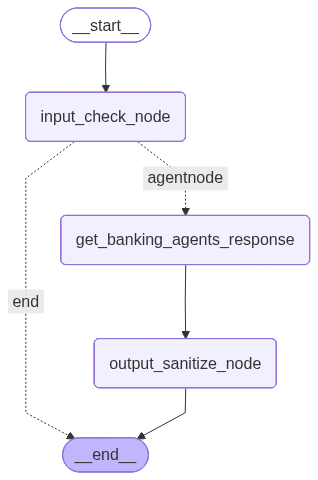

In [52]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [61]:
config = {"configurable": {"thread_id": "6"}}

graph.invoke({
  'messages': ['give me my bank balance']
}, config)

input_check_node called 
 content='yes' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 89, 'total_tokens': 91, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_f99638a8d7', 'id': 'chatcmpl-D1QU2TYbRKEQgTaHmcW5eqbIimSZJ', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'detected': False, 'filtered': False}, 'protected_material_text': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}} id='lc_run--019bee79-8a01-7a41-8f10-475707c00a03-0' tool_calls=[] invalid_tool_calls=[] usage_metadata={'input_tokens': 89, 'output_tokens': 2, 'total_tokens': 91, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}} get_banking_agents_response called 
 output_sanitize_node called {'messages': [HumanMessage(content='give me my bank balance', additional_kwargs={}, response_metadata={}, id='649ec867-9b2a-468b-a792-5c50ecfeac3d'),
 AIMessage(content='Your current bank balance is 5,000. If you need assistance with any transactions or have further questions, let me know!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 90, 'total_tokens': 118, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_b9041e10b4', 'id': 'chatcmpl-D1QU4HWvTjGmfDJXMDsJ9WFSof6kt', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'detected': False, 'filtered': False}, 'protected_material_text': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}, id='lc_run--019bee79-93ca-7f02-983f-ed258f4f242f-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 90, 'output_tokens': 28, 'total_tokens': 118, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})],
 'agent_trace': {'messages': [HumanMessage(content='give me my bank balance', additional_kwargs={}, response_metadata={}, id='649ec867-9b2a-468b-a792-5c50ecfeac3d'),
 AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 64, 'total_tokens': 76, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'mo

In [63]:
from langchain_openai import AzureOpenAIEmbeddings

embeddings = AzureOpenAIEmbeddings(
    model="text-embedding-3-large")
vector = embeddings.embed_query("hello, world!")

In [65]:
vector[:3]

[-0.017173640429973602, -0.024217132478952408, -0.014735509641468525]

In [66]:
from langgraph.store.memory import InMemoryStore
import uuid

in_memory_store = InMemoryStore()
store = InMemoryStore(index={"embed": embeddings})

In [67]:
user_id = "1"
namespace_for_memory = (user_id, 'food')

store.put(
    namespace_for_memory,
    str(uuid.uuid4()),
    {"food_preference": "I love Italian cuisine", "context": "Discussing dinner plans"},
)

store.put(
    namespace_for_memory,
    str(uuid.uuid4()),
    {"food_preference": "I hate chinese", "context": "Discussing lunch plans"},
)

store.put(
    namespace_for_memory,
    str(uuid.uuid4()),
    {"food_preference": "I like hyderabad biryani", "context": "Discussing breakf plans"},
)

# 25. Add to Store
store.put(
    namespace_for_memory,
    str(uuid.uuid4()),
    {"food_preference": "I like masala dosa", "context": "Discussing dinner plans"},
)

In [74]:
# 26. Search Store
memories = store.search(
    namespace_for_memory,
    query="foods for dinner",
    limit=2
)
for memory in memories:
  print(memory.value)

{'food_preference': 'I love Italian cuisine', 'context': 'Discussing dinner plans'} {'food_preference': 'I like masala dosa', 'context': 'Discussing dinner plans'}

In [75]:
user_id = "1"
namespace_for_memory = (user_id, 'banking')

store.put(
    namespace_for_memory,
    str(uuid.uuid4()),
    {"risk_apetite": "I like lower risk"},
)

# 25. Add to Store
store.put(
    namespace_for_memory,
    str(uuid.uuid4()),
    {"age": "25", "profession": "software engineer"},
)

# 25. Add to Store
store.put(
    namespace_for_memory,
    str(uuid.uuid4()),
    {"financial free goal": "40 years"},
)

In [95]:
messagse['messages'][:-1] + [HumanMessage(content='string')]


[HumanMessage(content='string', additional_kwargs={}, response_metadata={})]

In [117]:
from langchain.messages import HumanMessage

def input_check_node(state: AgentState):
  user_query = state['messages'][-1]
  
  memories = store.search(
      namespace_for_memory,
      query=user_query.content,
      limit=2
  )
  
  long_term_memory_scan = [str(memory.value) for memory in memories]

  new_context = f"{user_query} \n context from long term memory: {long_term_memory_scan}"
  print(new_context)

  messages = state['messages'][:-1] + [HumanMessage(content=new_context)]
    
  print('input_check_node called')
  return {'messages': messages}


def fetch_relavent_long_term_memory(state: AgentState):
  user_query = state['messages'][-1]
  
  response = llm.invoke(f"""
  for long term reference, lets identify if user is talking about any type of  financial preferences about accounts, or limits or certain special instructions, if yes, then summarize and return the preference in short and crisp manner
  if there is no preference, just return a blank string without any content

  User Query: {user_query}
  """)
  print(response)
  if response.content != "":
    store.put(
      namespace_for_memory,
      str(uuid.uuid4()),
      {'financial_preferences': response.content}
    )
  return state

In [118]:
graph_builder = StateGraph(AgentState)
graph_builder.add_node('input_check_node', input_check_node)
graph_builder.add_node('get_banking_agents_response', get_banking_agents_response)
graph_builder.add_node('output_sanitize_node', output_sanitize_node)
graph_builder.add_node('fetch_relavent_long_term_memory', fetch_relavent_long_term_memory)

graph_builder.add_edge(START, 'input_check_node')
graph_builder.add_conditional_edges('input_check_node', decision_node, {'agentnode': 'get_banking_agents_response', 'end': END})
# graph_builder.add_edge('input_check_node', 'get_banking_agents_response')
graph_builder.add_edge('get_banking_agents_response', 'fetch_relavent_long_term_memory')
graph_builder.add_edge('fetch_relavent_long_term_memory', 'output_sanitize_node')

graph = graph_builder.compile(store=store)

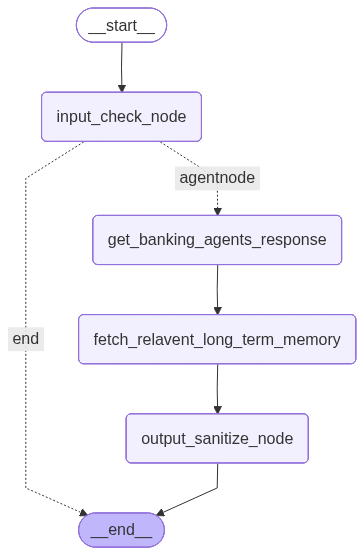

In [109]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [120]:
messagse = {
  'messages': ['help get my bank balance and I would like to add a special instruction that, dont allow withdraw when balance is 5000']
}

graph.invoke(messagse)

content='help get my bank balance and I would like to add a special instruction that, dont allow withdraw when balance is 5000' additional_kwargs={} response_metadata={} id='355b7a28-f4e9-4196-b4f9-75b92c3ad0e0' context from long term memory: ["{'financial free goal': '40 years'}", "{'financial_preferences': 'Understood! For any future inputs, I will identify and summarize any financial preferences mentioned. If there are none, I will return a blank string.'}"] input_check_node called 
 content='yes' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 208, 'total_tokens': 210, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_f99638a8d7', 'id': 'chatcmpl-D1R9JDQsxLpylTnpM4VJTSxW4nZka', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'detected': False, 'filtered': False}, 'protected_material_text': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}} id='lc_run--019beea0-98cc-7942-8f81-c1a9018ee3b8-0' tool_calls=[] invalid_tool_calls=[] usage_metadata={'input_tokens': 208, 'output_tokens': 2, 'total_tokens': 210, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}} get_banking_agents_response called 
 content='No withdrawals allowed when balance is 5,000.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 587, 'total_tokens': 599, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_f99638a8d7', 'id': 'chatcmpl-D1R9MXONNY2KGIrqAx8EFDCioebrk', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'detected': False, 'filtered': False}, 'protected_material_text': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}} id='lc_run--019beea0-a6e3-7323-9e9e-909d3be2eb38-0' tool_calls=[] invalid_tool_calls=[] usage_metadata={'input_tokens': 587, 'output_tokens': 12, 'total_tokens': 599, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}} 
 output_sanitize_node called {'messages': [HumanMessage(content='help get my bank balance and I would like to add a special instruction that, dont allow withdraw when balance is 5000', additional_kwargs={}, response_metadata={}, id='355b7a28-f4e9-4196-b4f9-75b92c3ad0e0'),
 HumanMessage(content='content=\'help get my bank balance and I would like to add a special

In [121]:
# 26. Search Store
memories = store.search(
    namespace_for_memory,
    query="special instructions",
    limit=2
)
for memory in memories:
  print(memory.value)

{'financial_preferences': 'No withdrawals allowed when balance is 5,000.'} {'financial_preferences': 'Understood! For any future inputs, I will identify and summarize any financial preferences mentioned. If there are none, I will return a blank string.'}